<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_%EC%A3%BC%EC%8B%9D%EB%B4%87_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주식_봇__강화학습

In [ ]:
!pip install pykrx
!pip install finance-datareader
!pip install opendartreader
!pip install --upgrade opendartreader

In [2]:
def pro_equ(code, start, end):
    # OpenDartReader 사용
    api_key = '9b9157d4313a84f3141d73f879c5d239d49bb0ce'
    dart = OpenDartReader(api_key)
    arr = [] # 재무 정보
    index = [] # 계산지표
    
    # 주식정보
    if type(code) != str:
        code = str(code).zfill(6)       
    
    if type(start) != str:
        start = str(start)
    
    if type(end) != str:
        end = str(end)
        
    stock = fdr.DataReader(code, start = str(int(start)+1), end = end)  # 2021 지표 <- 2020,2019 데이터로 만듬
    stock = stock.reset_index()
    stock['year'] = stock['Date'].dt.year
    stock['PER'] = 0.1
    stock['PBR'] = 0.1
    stock['ROE'] = 0.1
    stock['ROA'] = 0.1
#     print(stock.info())
    #         ------------------------
    
    small = dart.report('005930', '소액주주', int(datetime.datetime.now().strftime("%Y"))-1, reprt_code=11014)
    stock_tot_co = int(small['stock_tot_co'].str.replace(',', '')) # 총 발행 주식 수
    
    for i in range(int(start[:4]), int(end[:4])):
        # https://opendart.fss.or.kr/guide/detail.do?apiGrpCd=DS003&apiId=2019016 --> 입력변수 명 참고
        # corp: 종목코드, bsns_year: 사업연도, reprt_code: 보고서코드
        # (1분기보고서 : 11013, 반기보고서 : 11012, 3분기보고서 : 11014, 사업보고서 : 11011)
        fs_before = dart.finstate_all(corp = code, bsns_year= str(i-1), fs_div='CFS', reprt_code=11011) 
        fs_present = dart.finstate_all(corp = code, bsns_year= i, fs_div='CFS', reprt_code=11014)

        # 자본, 부채는 당기 금액('thstrm_amount') 값을 통해서 구함
#         equity = int(fs_present.loc[fs_present['sj_div'].isin(['BS']) & fs_present['account_id'].isin(['ifrs-full_Equity']), 'thstrm_amount'].replace(",", "")) # 당기자본(자본총계)
        equity = int(fs_present.loc[fs_present['sj_div'].isin(['BS']) & fs_present['account_nm'].isin(['자본총계']), 'thstrm_amount'])
#         print(equity)
#         liability = int(fs_present.loc[fs_present['sj_div'].isin(['BS']) & fs_present['account_id'].isin(['ifrs-full_Liabilities']), 'thstrm_amount'].replace(",", "")) # 당기부채(부채총계)
        liability = int(fs_present.loc[fs_present['sj_div'].isin(['BS']) & fs_present['account_nm'].isin(['부채총계']), 'thstrm_amount'].replace(",", ""))
#         print(liability)
        # 자산 총계
        assets = equity + liability
        
        # <예시>
        # 2019 4분기 ~ 2020 3분기까지의 당기순이익의 합을 구하려면 2019년 4분기 당기순이익과 2020년 1분기 ~ 3분기 당기순이익의 합을 알아여함
        # 2020년 1분기 ~ 3분기 당기순이익의 합은 2020년 3분기 손익계산서에서 'thstrm_add_amount' 값을 가져오면 되고
        # 2019년 4분기 당기순이익은 2019년 전체 당기순이익에서 2019년 1분기 ~ 3분기 당기순이익의 합을 빼서 구할 수 있음
        
        # frmtrm_add_amount --> 전기 금액, thstrm_amount ---> 당기 금액, thstrm_add_amount --> 당기 누적금액
#         profit_before_3Q = int(fs_present.loc[fs_present['sj_div'].isin(['IS']) & fs_present['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), 'frmtrm_add_amount'].replace(",", "")) # 당기순이익
        
    
        sj_l = ['IS','CIS']
        sj = []
        sj_b =[]
        for re in range(len(sj_l)):
            if sj_l[re] in list(fs_present['sj_div'].unique()):
                sj.append(sj_l[re])
            if sj_l[re] in list(fs_before['sj_div'].unique()):
                sj_b.append(sj_l[re])
        
        
        pf_l = ['지배기업의 소유주에게 귀속되는 당기순이익(손실)','당기순이익','당기순이익(손실)','분기순이익','분(반)기순이익(손실)','순이익(손실)','분기순이익(손실)','연결분기순이익','연결당기순이익', '연결분기순이익(손실)']
        for k in range(len(pf_l)):
            if pf_l[k] in list(fs_present.loc[fs_present['sj_div'].isin(sj),'account_nm'].unique()):
                pf = pf_l[k]
            if pf_l[k] in list(fs_before['account_nm'].unique()):
                pf_b = pf_l[k]     
        
        
#         print(pf)
        profit_before_3Q = int(fs_present.loc[fs_present['sj_div'].isin(sj) & fs_present['account_nm'].isin([pf]), 'frmtrm_add_amount'].iloc[0].replace(",", ""))
#         print(profit_before_3Q)
#         profit_before = int(fs_before.loc[fs_before['sj_div'].isin(['IS']) & fs_before['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), 'thstrm_amount'].replace(",", "")) # 당기순이익
        profit_before = int(fs_before.loc[fs_before['sj_div'].isin(sj_b) & fs_before['account_nm'].isin([pf_b]), 'thstrm_amount'].iloc[0].replace(",", ""))
#         print(profit_before)
#         profit_present = int(fs_present.loc[fs_present['sj_div'].isin(['IS']) & fs_present['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), 'thstrm_add_amount'].replace(",", "")) # 당기순이익
        profit_present = int(fs_present.loc[fs_present['sj_div'].isin(sj) & fs_present['account_nm'].isin([pf]), 'thstrm_add_amount'].iloc[0].replace(",", "")) # 당기순이익
#         print(profit_present)
        profit = (profit_before-profit_before_3Q) + profit_present
        
        a = (equity, liability, assets, profit, stock_tot_co) 
        # 자본총계(당기자본), 부채총계(당기부채), 자산총계, 당기 순이익, 총 발행 주식수
        arr.append(a)
        
#         - PER(주가 수익률) : 주가를 1주당 순이익(EPS)로 나눈 값
#         - PBR(주가 순자산 비율) : 주가를 1주당 순자산가치로 나눈 값
#         - ROE(자기자본이익률) : 당기순이익을 순자산(자기자본)으로 나눈 값
#         - ROA(총자산수익률) : 당기순이익을 자산총액으로 나눈 값
        
    
        ROA = profit/assets
        stock['ROA'][stock[stock.year == i+1].index] = ROA
        
        
        EPS = profit/stock_tot_co
        PER = stock['Close'][stock[stock.year == i+1].index]/EPS
        stock['PER'][stock[stock.year == i+1].index] = PER

#         stock['PER'][stock[stock['Date'].dt.year == i+1].index] = PER
#         PER = stock[stock['Date'].dt.year == i+1]['Close']/EPS
        
        BPS = equity/stock_tot_co
        PBR = stock['Close'][stock[stock.year == i+1].index]/BPS
#         PBR = stock[stock['Date'].dt.year == i+1]['Close']/BPS
        stock['PBR'][stock[stock.year == i+1].index] = PBR
    
    
    
#         for i in PER.index:
#             stock['PER'][i] = PER[i]
#             stock['PBR'][i] = PBR[i]
        
        b = (EPS,BPS)
        # EPS: 순이익/총발행주식수 --> 주당 수익?
        # BPS: 순자산/총발행 주식수 --> 주당 자산가치?
        
        index.append(b)
        
    stock['ROE'] = stock['PBR']/stock['PER']
    
    return stock

## 모델 실습

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50

             Open   High    Low  Close    Volume    Change  Action
Date                                                              
2020-12-22  72500  73200  72100  72300  16304910 -0.009589       1
2020-12-23  72400  74000  72300  73900  19411326  0.022130       1
2020-12-24  74100  78800  74000  77800  32502870  0.052774       1
2020-12-28  79000  80100  78200  78700  40085044  0.011568       2
2020-12-29  78800  78900  77300  78300  30339449 -0.005083       2
...           ...    ...    ...    ...       ...       ...     ...
2021-09-09  76400  766

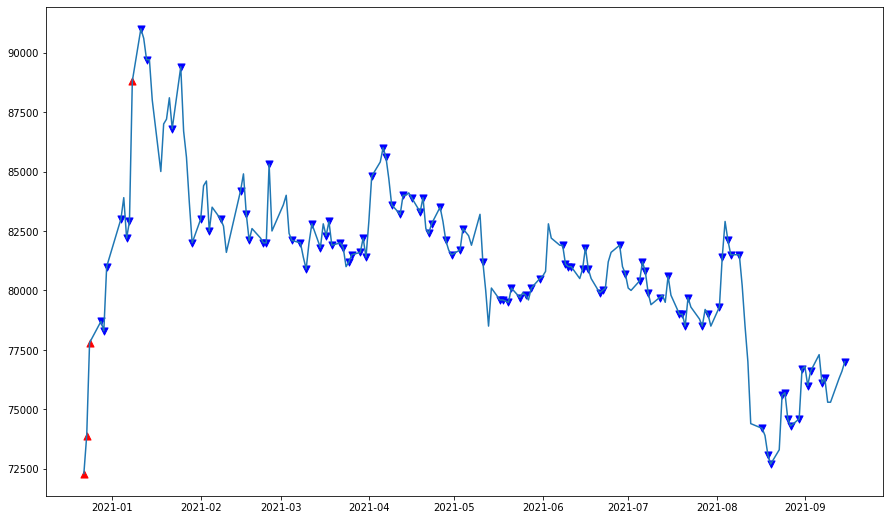

In [22]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
# import pandas_datareader as pdr
# from pykrx import stock
import matplotlib.pyplot as plt

# 금융정보 조회하기
def dataset_loaderKR(stock_name, start, end, train_ratio=0.8):
  start_date = start
  end_date = end
  sample_code = stock_name
  dataset = fdr.DataReader( sample_code, start = start_date, end = end_date )
  dataset['Close'] = dataset['Close']
  date_split = str(dataset.index[int(train_ratio*len(dataset))])

  return dataset[:date_split], dataset[date_split:], date_split

# 데이터 불러오기
# 주식가격 로딩
import FinanceDataReader as fdr
import datetime
start_date = '20180101'
end_date = datetime.datetime.now().strftime("%Y%m%d")
sample_code = '005930'

(train, test, date_split) = dataset_loaderKR(sample_code, start = start_date, end = end_date)


# ENV 설정
class Environment1:
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0
        
        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

# MODEL
class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

# 학습 시키기
env = Environment1(train)
env.reset()

hidden_size = 100
input_size = env.history_t+1
output_size = 3
USE_CUDA = False
LR = 0.001

Q = Q_Network(input_size, hidden_size, output_size)
Q_ast = copy.deepcopy(Q)

if USE_CUDA:
    Q = Q.cuda()
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

epoch_num = 50
step_max = len(env.data)-1
memory_size = 200
batch_size = 50
gamma = 0.97

obs, reward, done = env.step(5)

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 20
show_log_freq = 5

start = time.time()
for epoch in range(epoch_num):
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0

    while not done and step < step_max:
        # select act
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()

        # act
        obs, reward, done = env.step(pact)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            #print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
    print("Epoch %d" % (epoch+1))

# TEST
test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print( sample_code, "결과")
print( "손익결과 $%.2f" % round(test_profits,2) )

if next_action == 2:
	print('하락!')
elif next_action == 1:
	print('증가!')
else:
	print('유지 - 확률 반반!')

buy_dates = test.loc[test['Action'] ==1].index.values
sell_dates = test.loc[test['Action'] ==2].index.values

buy_close = test.loc[test['Action'] ==1, 'Close'].values
sell_close = test.loc[test['Action'] ==2, 'Close'].values

fig = plt.figure(figsize=(15,9))

plt.plot(test['Close'])
plt.scatter(buy_dates, buy_close, label='skitscat', color='red', s=50, marker="^")
plt.scatter(sell_dates, sell_close, label='skitscat', color='blue', s=50, marker="v")
plt.show()

## 결과 확인

In [23]:
Q.forward

<bound method Q_Network.forward of Q_Network(
  (fc_val): Sequential(
    (0): Linear(in_features=91, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)>

In [24]:
test

,Open,High,Low,Close,Volume,Change,Action
Date,,,,,,,
2020-12-22,72500,73200,72100,72300,16304910,-0.009589,1
2020-12-23,72400,74000,72300,73900,19411326,0.022130,1
2020-12-24,74100,78800,74000,77800,32502870,0.052774,1
2020-12-28,79000,80100,78200,78700,40085044,0.011568,2
2020-12-29,78800,78900,77300,78300,30339449,-0.005083,2
...,...,...,...,...,...,...,...
2021-09-09,76400,76600,75000,75300,17600770,-0.013106,0
2021-09-10,75300,75600,74800,75300,10103212,0.000000,0
2021-09-13,75200,76300,75100,76300,11397775,0.013280,0


In [25]:
test['act'] = np.where((test['Change'] * test['Close']) > (0.1 * test['Close']),1,
                       np.where((test['Change'] * test['Close']) < (0.1 * test['Close']), 2,0)) # 상승, 하락, 보합

In [26]:
test.Action.value_counts()

2    102
0     77
1      4
Name: Action, dtype: int64

In [27]:
len(test[test.Action == test.act])/len(test)

0.5573770491803278

## 결과 저장

In [28]:
test.to_csv('삼성전자_RL_재무.csv', index=False)

In [29]:
# 모델저장
torch.save(Q,'samsung_rl_재무.h5')

In [30]:
(train, test, date_split) = dataset_loaderKR(sample_code, start = start_date, end = end_date)

In [31]:
# 모델 로딩
model = torch.load('samsung_rl_재무.h5')

test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print( sample_code, "결과")
print( "손익결과 $%.2f" % round(test_profits,2) )


             Open   High    Low  Close    Volume    Change  Action
Date                                                              
2020-12-22  72500  73200  72100  72300  16304910 -0.009589       1
2020-12-23  72400  74000  72300  73900  19411326  0.022130       1
2020-12-24  74100  78800  74000  77800  32502870  0.052774       1
2020-12-28  79000  80100  78200  78700  40085044  0.011568       2
2020-12-29  78800  78900  77300  78300  30339449 -0.005083       2
...           ...    ...    ...    ...       ...       ...     ...
2021-09-09  76400  76600  75000  75300  17600770 -0.013106       0
2021-09-10  75300  75600  74800  75300  10103212  0.000000       0
2021-09-13  75200  76300  75100  76300  11397775  0.013280       0
2021-09-14  77100  77700  76600  76600  18167057  0.003932       0
2021-09-15  77400  77400  76400  77000  12500473  0.005222       2

[183 rows x 7 columns]

005930 결과
손익결과 $14300.00


In [32]:
test['act'] = np.where((test['Change'] * test['Close']) > (0.1 * test['Close']),1,
                       np.where((test['Change'] * test['Close']) < (0.1 * test['Close']), 2,0)) # 상승, 하락, 보합

In [33]:
len(test[test.Action == test.act])/len(test)

0.5573770491803278